# Getting started with the LCDB (Learning Curve Database) and Learning Curve Analysis

Welcome to this introductory Jupyer Notebook on the Learning Curve Database (**LCDB**) Python package. This notebook is designed to guide new users through  the functionalities offered by the **LCDB**. The **LCDB** is tailored for exploring and analyzing learning curves, making it a valuable tool for both academic research and practical applications.

## What is the LCDB?

The **LCDB** Python Package is a comprehensive database that provides learning curves from various classification algorithms. Learning curves depict the prediction performance of a learning algorithm against the dataset size it has been trained on. These curves offer essential insights for decision-making, such as determining the value of gathering more data or selecting an optimal dataset size for sufficient accuracy.

The **LCDB** provides:
- Over 150GB of ground truth and prediction vectors for 20 classification algorithms from the scikit-learn library across 246 datasets.
- Prediction vectors recorded for models being trained on an amount of instances (anchors) that are rounded multiples of $\sqrt{2}$.
- Curve data for each learner with 25 stratified splits at each anchor for training, validation and test data.
- Runtimes for model training and prediction.

## Getting Started

This notebook assumes a foundational knowledge of Python and Machine Learning concepts. If you're new to these areas, consider reviewing some basic materials before getting started.
For more background on the LCDB or the theory of Learning Curves, you can refer to [this paper](https://research.tudelft.nl/en/publications/lcdb-10-an-extensive-learning-curves-database-forclassification-t) or [this paper](https://research.tudelft.nl/en/publications/the-shape-of-learning-curves-a-review) respectively.

## What You Will Learn?

This notebook will walk you through:

- **Installing the LCDB**: The basic steps to getting the LCDB installed and running in your Python environment.
- **Retrieving and Analyzing Learning Curves**: How to access learning curves for different metrics and datasets, and analyze their implications.
- **Plotting and Interpreting Curves**: Utilizing built-in functions and plotting techniques to visualize learning curve data effectively.
- **Computing Metrics**: Using the prediction vectors to compute metrics like AUC and log-loss.
- **Understanding Training Times**: Analyzing the computational efficiency of different algorithms through their training times.
- **Exploring Meta-Features**: Delving into dataset-specific meta-features provided by LCDB.
- **Practical Applications**: Practical examples showcasing the utility of LCDB in Machine Learning research and development.

By the end of this notebook, you'll be equipped with the knowledge and skills to effecively utilize this tool in your academic and research endeavors. Let's get started!

# Part 1 : Installing the LCDB

Before describing the functionalities of the LCDB, it's essential to ensure that it's properly installed in your Python environment. This notebook assumes that the user has Python installed and knowledge of pip and virtual environments. The LCDB can be easily installed and accessed through the following API.

In [1]:
!pip install lcdb
!pip install openml
!pip install func_timeout

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)



You can verify the installation by trying to import LCDB in a Python interpreter or a Jupyter Notebook cell. We will also import the other libraries that will be used in this notebook, namely [NumPy](https://numpy.org/) and [Matplotlib](https://matplotlib.org).

In [1]:
import lcdb
import numpy as np
import matplotlib.pyplot as plt

To ensure you have the latest version of LCDB, you can periodically update it using:

In [3]:
!pip install --upgrade lcdb

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


With LCDB installed, you are now ready to start exploring its functionality. In the next section, we will dive into how to retrieve and analyze learning curves using LCDB.

# Part 2 : Retrieving and Analyzing Learning Curves

### Retrieving a Learning Curve

In this section, we'll explore how to access learning curves for different classification algorithms using the LCDB. We'll focus on a logistic regression model applied to the 'kr-vs-kp' dataset. For a complete list of supported datasets and learners, refer to the [LCDB GitHub README](https://github.com/fmohr/lcdb/blob/main/README.md). Each learner was executed with standard parametrization. You can find more information about each dataset on [OpenML](https://www.openml.org/), including a [detailed description of 'kr-vs-kp'](https://www.openml.org/search?type=data&sort=runs&id=3&status=active).

Here's how to retreive a learning curve using the dataset name.

In [5]:
curve = lcdb.get_curve("kr-vs-kp", "sklearn.linear_model.LogisticRegression")
anchors, scores_train, scores_valid, scores_test = curve

Alternatively, you can use the OpenML ID:


In [6]:
curve = lcdb.get_curve(3, "sklearn.linear_model.LogisticRegression")
anchors, scores_train, scores_valid, scores_test = curve

By default, the LCDB returns accuracy scores. The log-loss metric is also supported, which can be specified in a third positional argument.

In [7]:
curve_log_loss = lcdb.get_curve(3, "sklearn.linear_model.LogisticRegression", "logloss")

> **Note**: Some combinations of models and datasets might yield errors due to missing curves. For example you might encounter errors like **No curves found for learner sklearn.tree.DecisionTreeClassifier on openmlid 38** or **No curves found for openmlid 183**. These errors become more common for the datasets with larger ids. We are working on resolving these issues.

### Processing a Learning Curve

Before moving on to analyzing the curves, it's important to understand the structure of the learning curve data. We will start by examining the anchors, representing the number of data instances the model was trained on.

In [8]:
print(anchors)
print(len(anchors))

[16, 23, 32, 45, 64, 91, 128, 181, 256, 362, 512, 724, 1024, 1448, 2048, 2588]
16


The anchor sizes are of the sequence $(\sqrt{2})^i$ starting with $i=8$. The final anchor should be 90% of the dataset size. Next we will look at the scores returned for the curve.

In [9]:
print(np.shape(scores_train))
print(np.shape(scores_valid))
print(np.shape(scores_test))

(16, 125)
(16, 125)
(16, 125)


The learning curve is represented by the anchors together with three 2-dimensional lists, representing the training, validation and test scores respectively. The first dimension of the scores, 16 in this case, corresponds to the number of anchors which we saw above. This number will typically vary depending on the dataset you are using, as the datasets are of different sizes.
The second dimension will typically be 125 (for datasets with id<23) or 25 (for the remainder of the datasets), representing the stratified splits on which the model is trained on.

> **Note**: Some datasets return inhomogeneous 2-dimensional lists. For example, the training scores for logistic regression on dataset 21 (car dataset), the first list contains 120 elements, while the remaining 13 lists adhere to the expected size of 125 elements each. In this case using numpy.shape(...) would result in an error. We will see how to deal with this in the following example.

Let's take a closer look at the validation scores we retrieved for the Logistic Regression model on the kr-vs-kp dataset.

In [9]:
mean_scores_train = [np.mean(sublist) for sublist in scores_valid]
print(mean_scores_train)

[0.658692, 0.7141680000000001, 0.7606408, 0.8029703999999999, 0.8456111999999998, 0.8736383999999998, 0.8991047999999998, 0.9206399999999999, 0.9334999999999999, 0.9421959999999999, 0.9493376000000001, 0.9531432000000001, 0.9552528000000001, 0.9575008, 0.960476, 0.9628088]


By averagine the scores manually this way, we avoid running into issues with the inhomogeneously sized 2-dimensional lists. We now have curve data that is ready to be plotted and interpreted.

> **Note**: Issues with inhomogeneous 2-dimensional lists could mean that something went wrong in the training process for the learner, which could lead to less accurate measurements. It is always recommended to inspect the data manually.

# Part 3 : Plotting and Interpreting Curves

### Plotting Learning Curves

Vizualizing learning curves is an essential step in understanding the performance of different learning algorithms. The LCDB package provides built-in functions for quick plotting, and you can also use external libraries like [matplotlib](https://matplotlib.org) for more customized visualizations.

### Using LCDB's Built-in Plotting Functions

The LCDB package offers convenient functions to plot learning curves quickly.

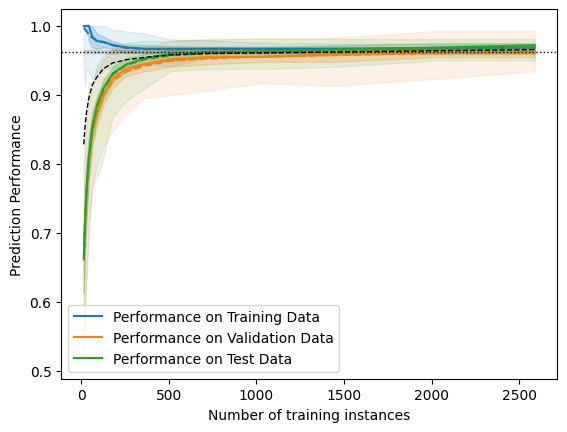

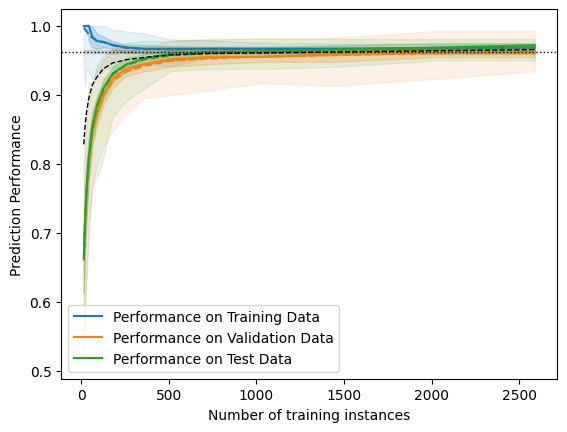

In [12]:
curve = lcdb.get_curve(3, "sklearn.linear_model.LogisticRegression")
lcdb.plot_train_and_test_curve(curve)

### Customizing wih Matplotlib

For more control over the plot, you can use matplotlib with your own axis objects. The following code displays a learning curve with the Accuracy metric and a second curve with the Log-Loss metric, each visualized on separate axes.

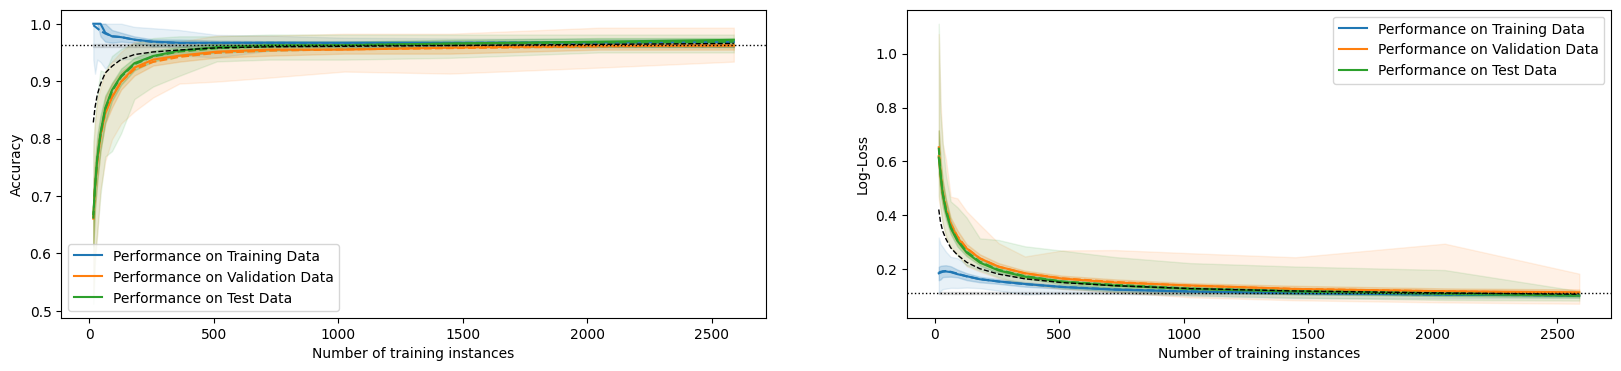

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
lcdb.plot_train_and_test_curve(curve, ax[0])
ax[0].set_ylabel("Accuracy")
lcdb.plot_train_and_test_curve(curve_log_loss, ax[1])
ax[1].set_ylabel("Log-Loss")
plt.show()

## ✨Practical Example: Plotting Learning Curves from Different Learners and Identifying Intersections

In this practical example, we will compare the learning curves of Logistic Regression and Decision Tree models on the dataset with ID 6 (letter). Our goal is to plot both learning curves on the same graph using matplotlib, and identify the point where they intersect.

### Step 1: Retrieving Validation Curves
First, we create a function to retrieve and average the validation learning curves for a specified model and dataset.t.

In [11]:
def get_validation_curve(model, dataset_id):
    """Retrieve the validation curve for a given model and dataset."""
    try:
        anchors, _, scores_valid, _ = lcdb.get_curve(dataset_id, model)
        means = [np.mean(sublist) for sublist in scores_valid]
        return anchors, means

    except Exception as e:
        print(f"Error with dataset_id: {dataset_id} and model: {model} - {str(e)}")
        return None, None

Now, we'll use this function to get the validation curves for our chosen models and dataset.


In [12]:
dataset_id = 6

anchors_logreg, validation_scores_logreg = get_validation_curve("sklearn.linear_model.LogisticRegression", dataset_id)
anchors_tree, validation_scores_tree = get_validation_curve("sklearn.tree.DecisionTreeClassifier", dataset_id)

### Step 2: Plotting and Intersection Analysis

Next, we define the logic to find the intersection point between the two curves and plot them together.

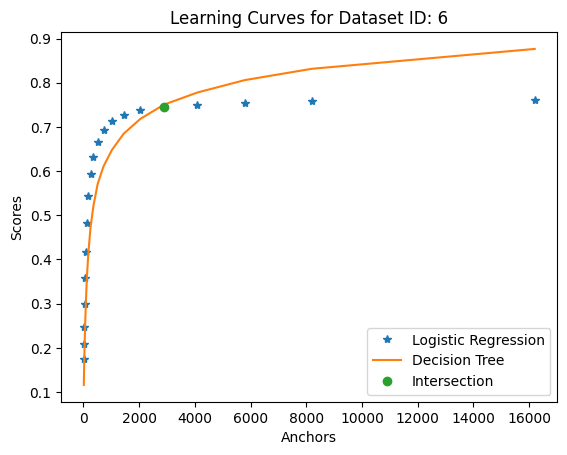

In [16]:
def check_intersection(anchors_X, scores_X, anchors_Y, scores_Y):
    """Check if validation curves intersect and return the intersection point."""
    for i in range(1, min(len(anchors_X), len(anchors_Y))):
        if (scores_X[i - 1] > scores_Y[i - 1] and scores_X[i] < scores_Y[i]) or \
           (scores_X[i - 1] < scores_Y[i - 1] and scores_X[i] > scores_Y[i]):
            return (anchors_X[i], scores_X[i])
    return None

def plot_curves(anchors_X, scores_X, anchors_Y, scores_Y, dataset_id):
    """Plot the learning curves and mark the intersection point."""
    plt.figure()
    plt.plot(anchors_X, scores_X,  '*', label="Logistic Regression")
    plt.plot(anchors_Y, scores_Y, label="Decision Tree")

    intersection = check_intersection(anchors_X, scores_X, anchors_Y, scores_Y)
    if intersection:
        plt.plot(*intersection, 'o', label='Intersection')

    plt.title(f"Learning Curves for Dataset ID: {dataset_id}")
    plt.xlabel("Anchors")
    plt.ylabel("Scores")
    plt.legend()
    plt.show()

plot_curves(anchors_logreg, validation_scores_logreg, anchors_tree, validation_scores_tree, dataset_id)

# Part 4 : Computing Metrics

This Notebook will be extended with further tutorials for computing metrics, working with training times, meta-features and examples of practical applications. For now you can refer to the [GitHub README](https://github.com/fmohr/lcdb/blob/main/README.md) and [some more example usages](https://github.com/fmohr/lcdb/blob/main/python/example-usage.ipynb).